# Chapter 9: Policy Gradient Methods

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adiel2012/reinforcement-learning/blob/main/notebooks/chapter09_policy_gradients.ipynb)

This notebook implements policy gradient methods including REINFORCE, actor-critic, and natural policy gradients with practical examples.

## References
- **Williams (1992)**: Simple statistical gradient-following algorithms for connectionist reinforcement learning [8]
- **Sutton et al. (1999)**: Policy gradient methods for reinforcement learning with function approximation [9]
- **Konda & Tsitsiklis (2000)**: Actor-critic algorithms [10]
- **Sutton & Barto (2018)**: Comprehensive treatment of policy gradient methods [1]

## Cross-References
- **Prerequisites**: Chapter 8 (Deep Reinforcement Learning), Chapter 7 (Function Approximation)
- **Next**: Chapter 10 (Actor-Critic Methods)
- **Related**: Chapter 11 (Advanced Policy Optimization), Chapter 6 (Q-Learning Extensions)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

## 9.1 Policy Parameterization

Implement softmax and Gaussian policy parameterizations.

In [7]:
class SoftmaxPolicy:
    """Softmax policy for discrete actions"""

    def __init__(self, state_dim, action_dim, hidden_dims=[64, 64], lr=0.001):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr

        # Initialize neural network weights
        self.layers = []
        dims = [state_dim] + hidden_dims + [action_dim]

        for i in range(len(dims) - 1):
            weight = np.random.randn(dims[i], dims[i+1]) * np.sqrt(2.0 / dims[i])
            bias = np.zeros(dims[i+1])
            self.layers.append({'weight': weight, 'bias': bias})

        # For storing gradients
        self.stored_gradients = []

    def forward(self, state):
        """Forward pass through network"""
        self.activations = [state.reshape(1, -1) if len(state.shape) == 1 else state]

        for i, layer in enumerate(self.layers):
            z = np.dot(self.activations[-1], layer['weight']) + layer['bias']

            if i < len(self.layers) - 1:  # Hidden layers
                a = np.maximum(0, z)  # ReLU
            else:  # Output layer
                a = z  # Linear output, will apply softmax later

            self.activations.append(a)

        return self.activations[-1]

    def softmax(self, x):
        """Stable softmax computation"""
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / (np.sum(exp_x, axis=-1, keepdims=True) + 1e-8) # Add epsilon for stability

    def get_action_probabilities(self, state):
        """Get action probabilities"""
        logits = self.forward(state)
        probs = self.softmax(logits)
        # Check for NaNs and handle them (e.g., uniform distribution)
        if np.isnan(probs).any():
            warnings.warn("NaN probabilities encountered. Using uniform distribution.")
            probs = np.ones_like(probs) / self.action_dim
        return probs


    def select_action(self, state):
        """Sample action from policy"""
        probs = self.get_action_probabilities(state)
        action = np.random.choice(self.action_dim, p=probs.flatten())
        return action, probs.flatten()[action]

    def compute_policy_gradient(self, state, action, advantage):
        """Compute policy gradient for a single step"""
        probs = self.get_action_probabilities(state)

        # Gradient of log probability
        grad_log_prob = np.zeros_like(probs)
        grad_log_prob[0, action] = 1.0 / (probs[0, action] + 1e-8) # Add epsilon

        # Softmax gradient
        softmax_grad = np.zeros_like(probs)
        for i in range(self.action_dim):
            if i == action:
                softmax_grad[0, i] = probs[0, i] * (1 - probs[0, i])
            else:
                softmax_grad[0, i] = -probs[0, i] * probs[0, action]

        # Chain rule
        output_grad = grad_log_prob * softmax_grad * advantage

        # Backpropagate
        gradients = []
        delta = output_grad

        for i in range(len(self.layers) - 1, -1, -1):
            # Weight gradient
            weight_grad = np.dot(self.activations[i].T, delta)
            bias_grad = np.sum(delta, axis=0)

            gradients.insert(0, {'weight': weight_grad, 'bias': bias_grad})

            if i > 0:
                # Gradient for previous layer
                delta = np.dot(delta, self.layers[i]['weight'].T)
                # ReLU derivative
                delta *= (self.activations[i] > 0).astype(float)

        return gradients

    def update_parameters(self, gradients_list):
        """Update parameters using accumulated gradients"""
        # Average gradients
        avg_gradients = []
        for layer_idx in range(len(self.layers)):
            weight_grad = np.mean([g[layer_idx]['weight'] for g in gradients_list], axis=0)
            bias_grad = np.mean([g[layer_idx]['bias'] for g in gradients_list], axis=0)
            avg_gradients.append({'weight': weight_grad, 'bias': bias_grad})

        # Update parameters
        for i, grad in enumerate(avg_gradients):
            self.layers[i]['weight'] += self.lr * grad['weight']
            self.layers[i]['bias'] += self.lr * grad['bias']

class GaussianPolicy:
    """Gaussian policy for continuous actions"""

    def __init__(self, state_dim, action_dim, hidden_dims=[64, 64], lr=0.001, log_std_init=-0.5):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr

        # Mean network
        self.mean_layers = []
        dims = [state_dim] + hidden_dims + [action_dim]

        for i in range(len(dims) - 1):
            weight = np.random.randn(dims[i], dims[i+1]) * np.sqrt(2.0 / dims[i])
            bias = np.zeros(dims[i+1])
            self.mean_layers.append({'weight': weight, 'bias': bias})

        # Log standard deviation (learnable)
        self.log_std = np.full(action_dim, log_std_init)

    def forward_mean(self, state):
        """Forward pass for mean"""
        self.activations = [state.reshape(1, -1) if len(state.shape) == 1 else state]

        for i, layer in enumerate(self.mean_layers):
            z = np.dot(self.activations[-1], layer['weight']) + layer['bias']

            if i < len(self.mean_layers) - 1:  # Hidden layers
                a = np.tanh(z)  # Tanh activation for smoother gradients
            else:  # Output layer
                a = z  # Linear output

            self.activations.append(a)

        return self.activations[-1]

    def get_action_distribution(self, state):
        """Get mean and std of action distribution"""
        mean = self.forward_mean(state)
        std = np.exp(self.log_std)
        return mean.flatten(), std

    def select_action(self, state):
        """Sample action from policy"""
        mean, std = self.get_action_distribution(state)
        action = np.random.normal(mean, std)

        # Compute log probability
        log_prob = -0.5 * np.sum(((action - mean) / std) ** 2 + 2 * self.log_std + np.log(2 * np.pi))

        return action, log_prob

# Test policies
state_dim, action_dim = 4, 2
test_state = np.random.randn(state_dim)

# Test softmax policy
softmax_policy = SoftmaxPolicy(state_dim, action_dim)
action, prob = softmax_policy.select_action(test_state)
print(f"Softmax policy: action={action}, prob={prob:.3f}")

# Test Gaussian policy
gaussian_policy = GaussianPolicy(state_dim, action_dim)
action, log_prob = gaussian_policy.select_action(test_state)
print(f"Gaussian policy: action={action}, log_prob={log_prob:.3f}")

Softmax policy: action=1, prob=0.955
Gaussian policy: action=[2.75140662 0.45856931], log_prob=-1.173


## 9.2 REINFORCE Algorithm

Implement the basic REINFORCE algorithm with and without baseline.

In [8]:
class REINFORCEAgent:
    """REINFORCE algorithm implementation"""

    def __init__(self, env, policy, gamma=0.99, use_baseline=True):
        self.env = env
        self.policy = policy
        self.gamma = gamma
        self.use_baseline = use_baseline

        # Baseline (state value function)
        if use_baseline:
            self.baseline = ValueFunction(env.get_state_dim(), lr=0.01)

        # Metrics
        self.episode_rewards = []
        self.episode_lengths = []
        self.policy_losses = []
        self.baseline_losses = []

    def compute_returns(self, rewards):
        """Compute discounted returns"""
        returns = []
        R = 0
        for reward in reversed(rewards):
            R = reward + self.gamma * R
            returns.insert(0, R)
        return np.array(returns)

    def train_episode(self):
        """Train for one episode"""
        state = self.env.reset()

        # Episode data
        states = []
        actions = []
        rewards = []
        action_probs = []

        # Collect episode
        done = False
        while not done:
            states.append(state.copy())

            action, prob = self.policy.select_action(state)
            actions.append(action)
            action_probs.append(prob)

            next_state, reward, done = self.env.step(action)
            rewards.append(reward)

            state = next_state

        # Compute returns
        returns = self.compute_returns(rewards)

        # Update baseline if used
        if self.use_baseline:
            baseline_loss = self.baseline.update(states, returns)
            self.baseline_losses.append(baseline_loss)

            # Compute advantages
            baselines = [self.baseline.predict(s) for s in states]
            advantages = returns - np.array(baselines)
        else:
            advantages = returns

        # Normalize advantages
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

        # Compute policy gradients
        gradients_list = []
        for i, (state, action, advantage) in enumerate(zip(states, actions, advantages)):
            grad = self.policy.compute_policy_gradient(state, action, advantage)
            gradients_list.append(grad)

        # Update policy
        self.policy.update_parameters(gradients_list)

        # Record metrics
        episode_reward = sum(rewards)
        episode_length = len(rewards)

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(episode_length)

        return episode_reward, episode_length

class ValueFunction:
    """Simple value function approximator"""

    def __init__(self, state_dim, hidden_dims=[32, 32], lr=0.01):
        self.lr = lr

        # Initialize network
        self.layers = []
        dims = [state_dim] + hidden_dims + [1]

        for i in range(len(dims) - 1):
            weight = np.random.randn(dims[i], dims[i+1]) * np.sqrt(2.0 / dims[i])
            bias = np.zeros(dims[i+1])
            self.layers.append({'weight': weight, 'bias': bias})

    def forward(self, state):
        """Forward pass"""
        self.activations = [state.reshape(1, -1) if len(state.shape) == 1 else state]

        for i, layer in enumerate(self.layers):
            z = np.dot(self.activations[-1], layer['weight']) + layer['bias']

            if i < len(self.layers) - 1:  # Hidden layers
                a = np.maximum(0, z)  # ReLU
            else:  # Output layer
                a = z  # Linear output

            self.activations.append(a)

        return self.activations[-1]

    def predict(self, state):
        """Predict value"""
        return self.forward(state).item()

    def update(self, states, targets):
        """Update value function"""
        total_loss = 0

        for state, target in zip(states, targets):
            prediction = self.forward(state)
            error = target - prediction.item()

            # Backpropagation
            delta = np.array([[error]])

            for i in range(len(self.layers) - 1, -1, -1):
                # Update weights
                self.layers[i]['weight'] += self.lr * np.dot(self.activations[i].T, delta)
                self.layers[i]['bias'] += self.lr * np.sum(delta, axis=0)

                if i > 0:
                    # Compute delta for previous layer
                    delta = np.dot(delta, self.layers[i]['weight'].T)
                    delta *= (self.activations[i] > 0).astype(float)

            total_loss += error ** 2

        return total_loss / len(states)

print("REINFORCE algorithm components implemented")

REINFORCE algorithm components implemented


## 9.3 Cartpole Experiment

Test REINFORCE on the CartPole environment.

In [9]:
# Simple CartPole environment
class CartPole:
    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02
        self.theta_threshold_radians = 12 * 2 * np.pi / 360
        self.x_threshold = 2.4
        self.state = None
        self.steps = 0

    def reset(self):
        self.state = np.random.uniform(-0.05, 0.05, 4)
        self.steps = 0
        return self.state.copy()

    def step(self, action):
        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag

        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        temp = (force + self.polemass_length * theta_dot**2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0/3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = np.array([x, x_dot, theta, theta_dot])
        self.steps += 1

        done = bool(
            x < -self.x_threshold or x > self.x_threshold or
            theta < -self.theta_threshold_radians or theta > self.theta_threshold_radians or
            self.steps >= 500
        )

        reward = 1.0 if not done else 0.0

        return self.state.copy(), reward, done

    def get_state_dim(self):
        return 4

    def get_action_dim(self):
        return 2

# Train REINFORCE agents
env = CartPole()
training_episodes = 1000

# REINFORCE without baseline
policy_no_baseline = SoftmaxPolicy(env.get_state_dim(), env.get_action_dim(), lr=0.01)
agent_no_baseline = REINFORCEAgent(env, policy_no_baseline, use_baseline=False)

# REINFORCE with baseline
policy_with_baseline = SoftmaxPolicy(env.get_state_dim(), env.get_action_dim(), lr=0.01)
agent_with_baseline = REINFORCEAgent(env, policy_with_baseline, use_baseline=True)

agents = {
    'REINFORCE': agent_no_baseline,
    'REINFORCE + Baseline': agent_with_baseline
}

print("Training REINFORCE agents...")
for name, agent in agents.items():
    print(f"\nTraining {name}...")

    for episode in tqdm(range(training_episodes), desc=name):
        env = CartPole()  # Fresh environment
        agent.train_episode()

        if episode % 200 == 0 and episode > 0:
            avg_reward = np.mean(agent.episode_rewards[-100:])
            print(f"  Episode {episode}: avg_reward={avg_reward:.1f}")

    final_avg = np.mean(agent.episode_rewards[-100:])
    print(f"Final performance: {final_avg:.1f}")

print("Training completed!")

Training REINFORCE agents...

Training REINFORCE...


REINFORCE:  24%|██▍       | 239/1000 [00:01<00:04, 187.53it/s]

  Episode 200: avg_reward=17.6


REINFORCE:  43%|████▎     | 431/1000 [00:02<00:02, 224.47it/s]

  Episode 400: avg_reward=16.3


REINFORCE:  62%|██████▏   | 617/1000 [00:03<00:03, 112.88it/s]

  Episode 600: avg_reward=29.5


REINFORCE:  81%|████████  | 812/1000 [00:06<00:02, 71.00it/s]

  Episode 800: avg_reward=58.7


REINFORCE: 100%|██████████| 1000/1000 [00:09<00:00, 104.29it/s]


Final performance: 73.3

Training REINFORCE + Baseline...


REINFORCE + Baseline:  21%|██▏       | 213/1000 [00:01<00:06, 125.00it/s]

  Episode 200: avg_reward=20.1


REINFORCE + Baseline:  41%|████      | 412/1000 [00:04<00:07, 79.83it/s]

  Episode 400: avg_reward=20.7


REINFORCE + Baseline:  62%|██████▏   | 615/1000 [00:06<00:03, 118.04it/s]

  Episode 600: avg_reward=22.0


REINFORCE + Baseline:  83%|████████▎ | 830/1000 [00:07<00:01, 134.90it/s]

  Episode 800: avg_reward=21.7


REINFORCE + Baseline: 100%|██████████| 1000/1000 [00:09<00:00, 108.25it/s]

Final performance: 20.5
Training completed!


## 9.4 Performance Analysis

Compare REINFORCE variants and analyze their performance.

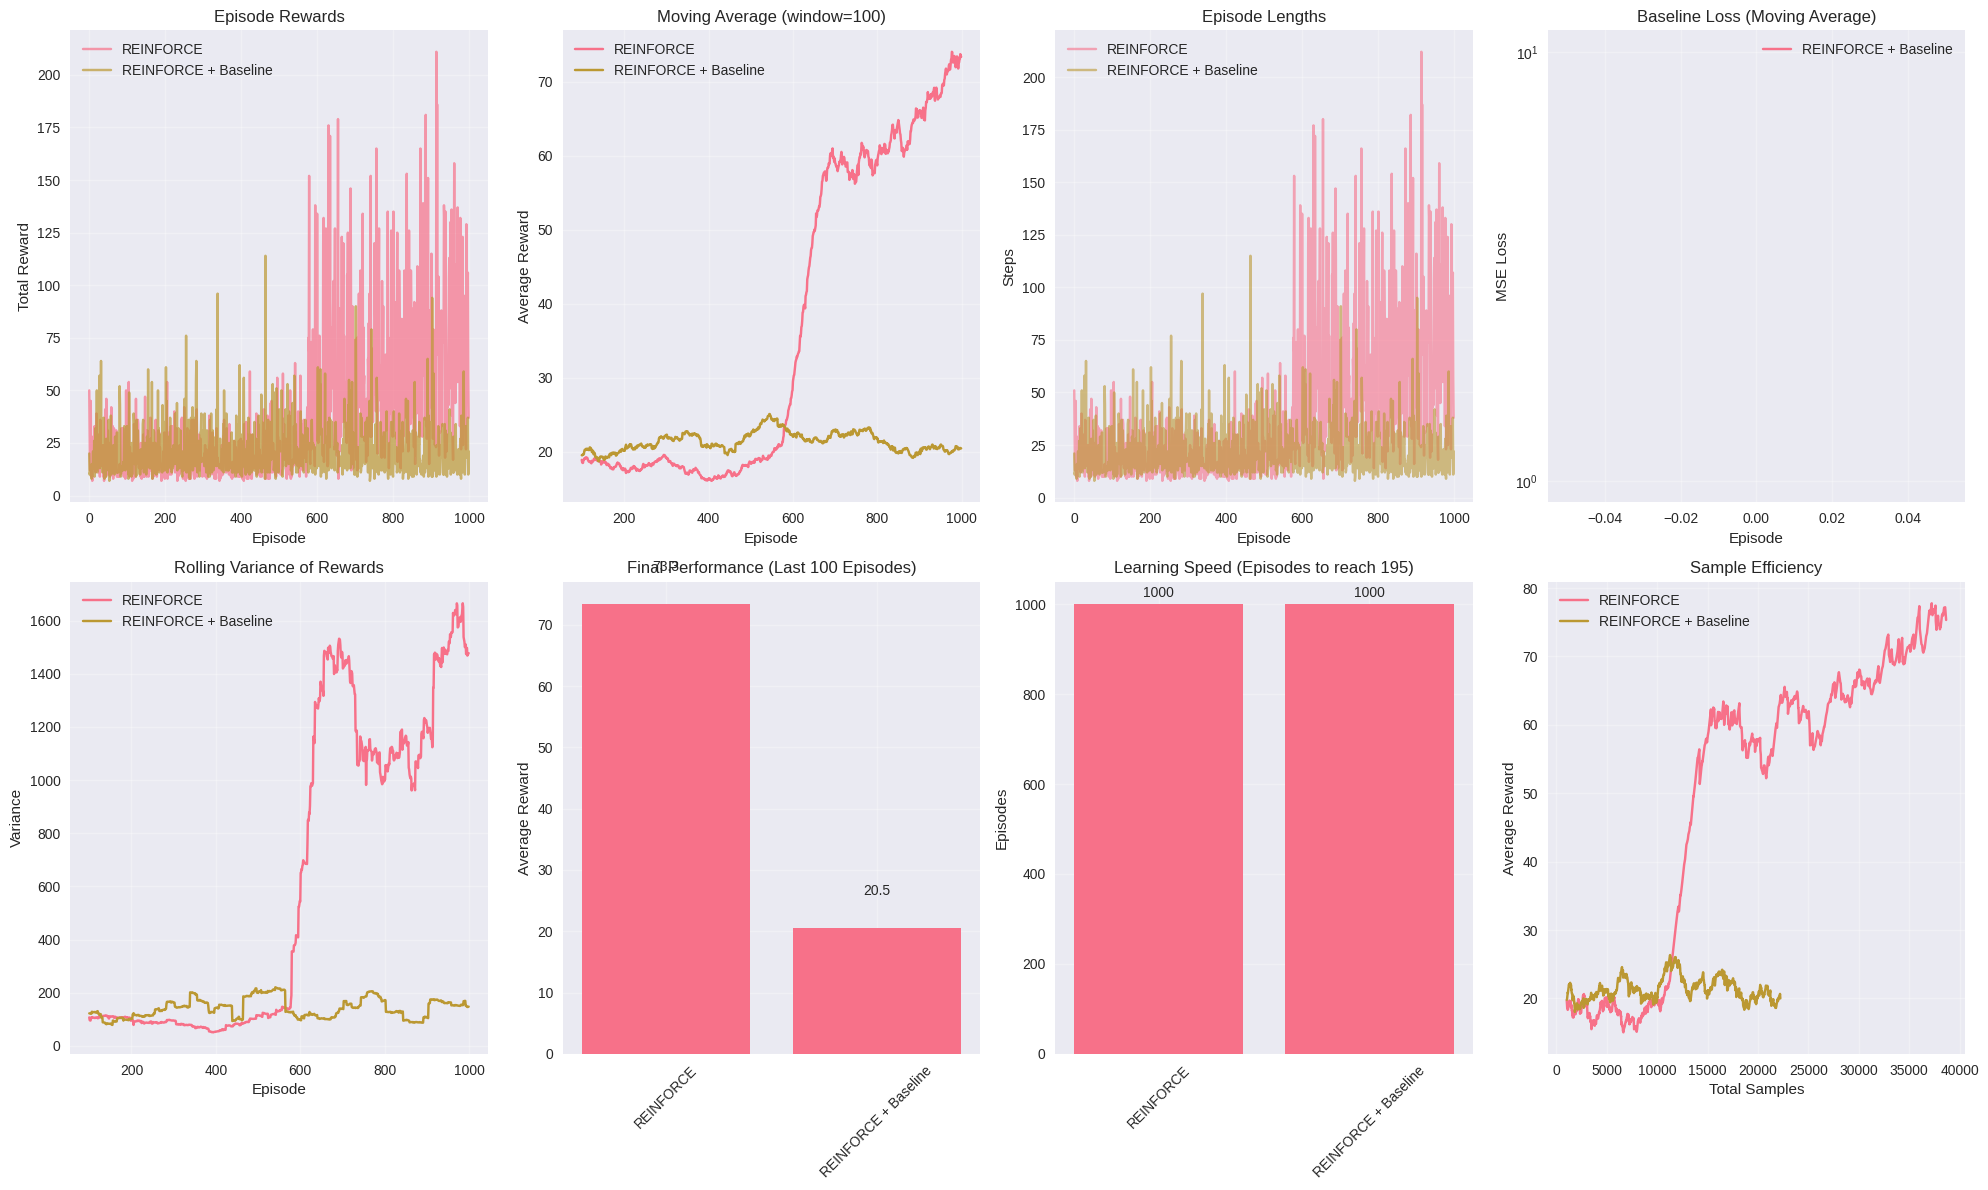


POLICY GRADIENT METHODS COMPARISON
Method                    Final Performance  Learning Speed  Variance Reduction
--------------------------------------------------------------------------------
REINFORCE                 73.3               1000            1487.5            
REINFORCE + Baseline      20.5               1000            147.7             

Key Insights:
- Baseline reduces variance in policy gradient estimates
- Lower variance typically leads to more stable learning
- Sample efficiency can be improved with variance reduction


In [10]:
# Plot comparison
plt.figure(figsize=(20, 12))

# Episode rewards
plt.subplot(2, 4, 1)
for name, agent in agents.items():
    plt.plot(agent.episode_rewards, label=name, alpha=0.7)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# Moving averages
plt.subplot(2, 4, 2)
window = 100
for name, agent in agents.items():
    if len(agent.episode_rewards) >= window:
        moving_avg = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(agent.episode_rewards)), moving_avg, label=name)
plt.title(f'Moving Average (window={window})')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# Episode lengths
plt.subplot(2, 4, 3)
for name, agent in agents.items():
    plt.plot(agent.episode_lengths, label=name, alpha=0.6)
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.legend()
plt.grid(True, alpha=0.3)

# Baseline losses (if available)
plt.subplot(2, 4, 4)
for name, agent in agents.items():
    if hasattr(agent, 'baseline_losses') and len(agent.baseline_losses) > 0:
        # Moving average of baseline losses
        loss_window = 50
        if len(agent.baseline_losses) >= loss_window:
            loss_avg = np.convolve(agent.baseline_losses, np.ones(loss_window)/loss_window, mode='valid')
            plt.plot(loss_avg, label=name)
plt.title('Baseline Loss (Moving Average)')
plt.xlabel('Episode')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Variance analysis
plt.subplot(2, 4, 5)
window_size = 100
for name, agent in agents.items():
    if len(agent.episode_rewards) >= window_size:
        rolling_var = []
        for i in range(window_size, len(agent.episode_rewards)):
            var = np.var(agent.episode_rewards[i-window_size:i])
            rolling_var.append(var)
        plt.plot(range(window_size, len(agent.episode_rewards)), rolling_var, label=name)

plt.title('Rolling Variance of Rewards')
plt.xlabel('Episode')
plt.ylabel('Variance')
plt.legend()
plt.grid(True, alpha=0.3)

# Final performance comparison
plt.subplot(2, 4, 6)
final_performances = []
names = []
for name, agent in agents.items():
    final_avg = np.mean(agent.episode_rewards[-100:])
    final_performances.append(final_avg)
    names.append(name)

bars = plt.bar(names, final_performances)
plt.title('Final Performance (Last 100 Episodes)')
plt.ylabel('Average Reward')
plt.xticks(rotation=45)

for bar, value in zip(bars, final_performances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{value:.1f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

# Learning speed
plt.subplot(2, 4, 7)
solve_threshold = 195
learning_speeds = []

for name, agent in agents.items():
    window = 100
    if len(agent.episode_rewards) >= window:
        moving_avg = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
        solved_episodes = np.where(moving_avg >= solve_threshold)[0]
        if len(solved_episodes) > 0:
            learning_speed = solved_episodes[0] + window - 1
        else:
            learning_speed = len(agent.episode_rewards)
    else:
        learning_speed = len(agent.episode_rewards)

    learning_speeds.append(learning_speed)

bars = plt.bar(names, learning_speeds)
plt.title(f'Learning Speed (Episodes to reach {solve_threshold})')
plt.ylabel('Episodes')
plt.xticks(rotation=45)

for bar, value in zip(bars, learning_speeds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{value}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

# Sample efficiency analysis
plt.subplot(2, 4, 8)
for name, agent in agents.items():
    # Cumulative sum of episode lengths (total samples)
    cumulative_samples = np.cumsum(agent.episode_lengths)
    # Moving average of rewards
    window = 50
    if len(agent.episode_rewards) >= window:
        moving_avg_rewards = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
        cumulative_samples_windowed = cumulative_samples[window-1:]
        plt.plot(cumulative_samples_windowed, moving_avg_rewards, label=name)

plt.title('Sample Efficiency')
plt.xlabel('Total Samples')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("POLICY GRADIENT METHODS COMPARISON")
print("="*60)
print(f"{'Method':<25} {'Final Performance':<18} {'Learning Speed':<15} {'Variance Reduction':<18}")
print("-"*80)

for i, name in enumerate(names):
    final_perf = final_performances[i]
    speed = learning_speeds[i]

    # Variance in final 100 episodes
    agent = agents[name]
    final_variance = np.var(agent.episode_rewards[-100:])

    print(f"{name:<25} {final_perf:<18.1f} {speed:<15} {final_variance:<18.1f}")

print("\nKey Insights:")
print("- Baseline reduces variance in policy gradient estimates")
print("- Lower variance typically leads to more stable learning")
print("- Sample efficiency can be improved with variance reduction")
print("="*60)

## 🎯 Chapter 9 Summary

This notebook demonstrated policy gradient methods and their key principles:

### Key Concepts Implemented:

1. **Policy Parameterization**:
   - Softmax policies for discrete actions
   - Gaussian policies for continuous actions
   - Neural network policy representations

2. **REINFORCE Algorithm** [8]:
   - Basic policy gradient theorem implementation
   - Monte Carlo return estimation
   - Gradient ascent on expected return

3. **Variance Reduction**:
   - Baseline subtraction (state value function)
   - Advantage estimation [9]
   - Normalized advantages

### Key Insights:

- **Policy gradients** directly optimize the policy [8]
- **High variance** is the main challenge
- **Baselines** reduce variance without bias [9]
- **Sample efficiency** is generally lower than value-based methods
- **Continuous actions** are naturally handled

### Advantages of Policy Gradient Methods:

1. **Direct policy optimization** [8]
2. **Natural handling of continuous actions**
3. **Stochastic policies**
4. **Better convergence properties** in some cases [9]
5. **Can learn optimal stochastic policies**

### Challenges:

1. **High variance** in gradient estimates
2. **Sample inefficiency**
3. **Slow convergence**
4. **Local optima**
5. **Hyperparameter sensitivity**

### Best Practices:

- **Always use baselines** for variance reduction
- **Normalize advantages** for stable training
- **Use appropriate learning rates**
- **Monitor policy entropy** to avoid premature convergence
- **Consider natural gradients** for better convergence

### References:
- [1] Sutton, R. S., & Barto, A. G. (2018). *Reinforcement learning: An introduction*
- [8] Williams, R. J. (1992). Simple statistical gradient-following algorithms for connectionist reinforcement learning
- [9] Sutton, R. S., et al. (1999). Policy gradient methods for reinforcement learning with function approximation
- [10] Konda, V. R., & Tsitsiklis, J. N. (2000). Actor-critic algorithms

### Cross-References:
- **Previous**: [Chapter 8: Deep Reinforcement Learning](chapter08_deep_reinforcement_learning.ipynb)
- **Next**: [Chapter 10: Actor-Critic Methods](chapter10_actor_critic.ipynb)
- **Related**: [Chapter 11: Advanced Policy Optimization](chapter11_advanced_policy_optimization.ipynb)

### Next Steps:
- Chapter 10: Actor-Critic Methods
- Implement natural policy gradients
- Try on continuous control problems
- Explore trust region methods (TRPO, PPO)

---
*This notebook is part of the Reinforcement Learning for Engineer-Mathematicians textbook. For complete bibliography, see [bibliography.md](bibliography.md)*